# 0. Necessary Imports

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.optimizers import Adam, SGD 

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16

# 1. General Functions

In [55]:
def load_dataset(dataset):
    train_data = dataset.loc[dataset['Usage'] == 'Training']
    val_data = dataset.loc[dataset['Usage'] == 'PublicTest']
    test_data = dataset.loc[dataset['Usage'] == 'PrivateTest']
    
    X_train = train_data[['pixels']].values
    X_train = [np.fromstring(i[0], dtype=int, sep=' ') for i in X_train]
    X_train = [i.reshape((48, 48, 1)).astype('float32') for i in X_train]
    X_train = np.array(X_train) / 255.0
    
    X_val = val_data[['pixels']].values
    X_val = [np.fromstring(i[0], dtype=int, sep= ' ') for i in X_val]
    X_val = [i.reshape((48, 48, 1)).astype('float32') for i in X_val]
    X_val = np.array(X_val) / 255.0
    
    X_test = test_data[['pixels']].values
    X_test = [np.fromstring(i[0], dtype=int, sep=' ') for i in X_test]
    X_test = [i.reshape((48, 48, 1)).astype('float32') for i in X_test]
    X_test = np.array(X_test) / 255.0
    
    y_train = train_data[['emotion']].values
    y_train = tf.keras.utils.to_categorical(y_train)
    
    y_val = val_data[['emotion']].values
    y_val = tf.keras.utils.to_categorical(y_val)
    
    y_test = test_data[['emotion']].values
    y_test = tf.keras.utils.to_categorical(y_test)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [56]:
def plot(history):
    plt.style.use('default')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b-', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'g-', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()
    
    plt.plot(epochs, loss, 'b-', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'g-', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 2. Inital Data Exploration

In [57]:
df = pd.read_csv('datasets\\fer2013.csv')

In [58]:
df.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [59]:
print(df.shape)

(35887, 3)


In [60]:
df.count()

emotion    35887
pixels     35887
Usage      35887
dtype: int64

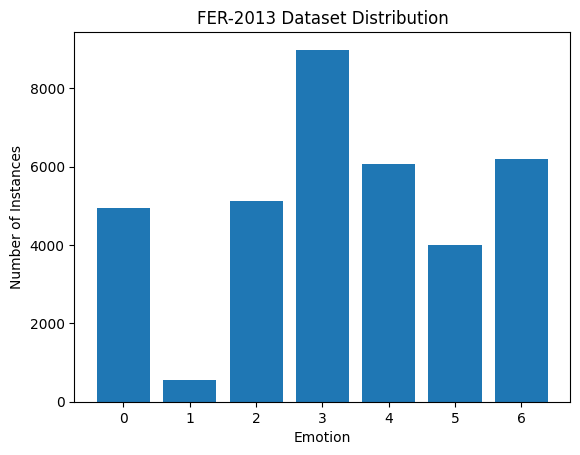

In [61]:
def plot_dataset_distribution():    
    plt.style.use('default')
    emotions_count = df['emotion'].value_counts()
    plt.bar(emotions_count.index, emotions_count.values)

    plt.title('FER-2013 Dataset Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Number of Instances')
    plt.show()
    
plot_dataset_distribution()

# 3. Loading in Dataset

In [62]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_dataset(df)

In [63]:
X_train.shape

(28709, 48, 48, 1)

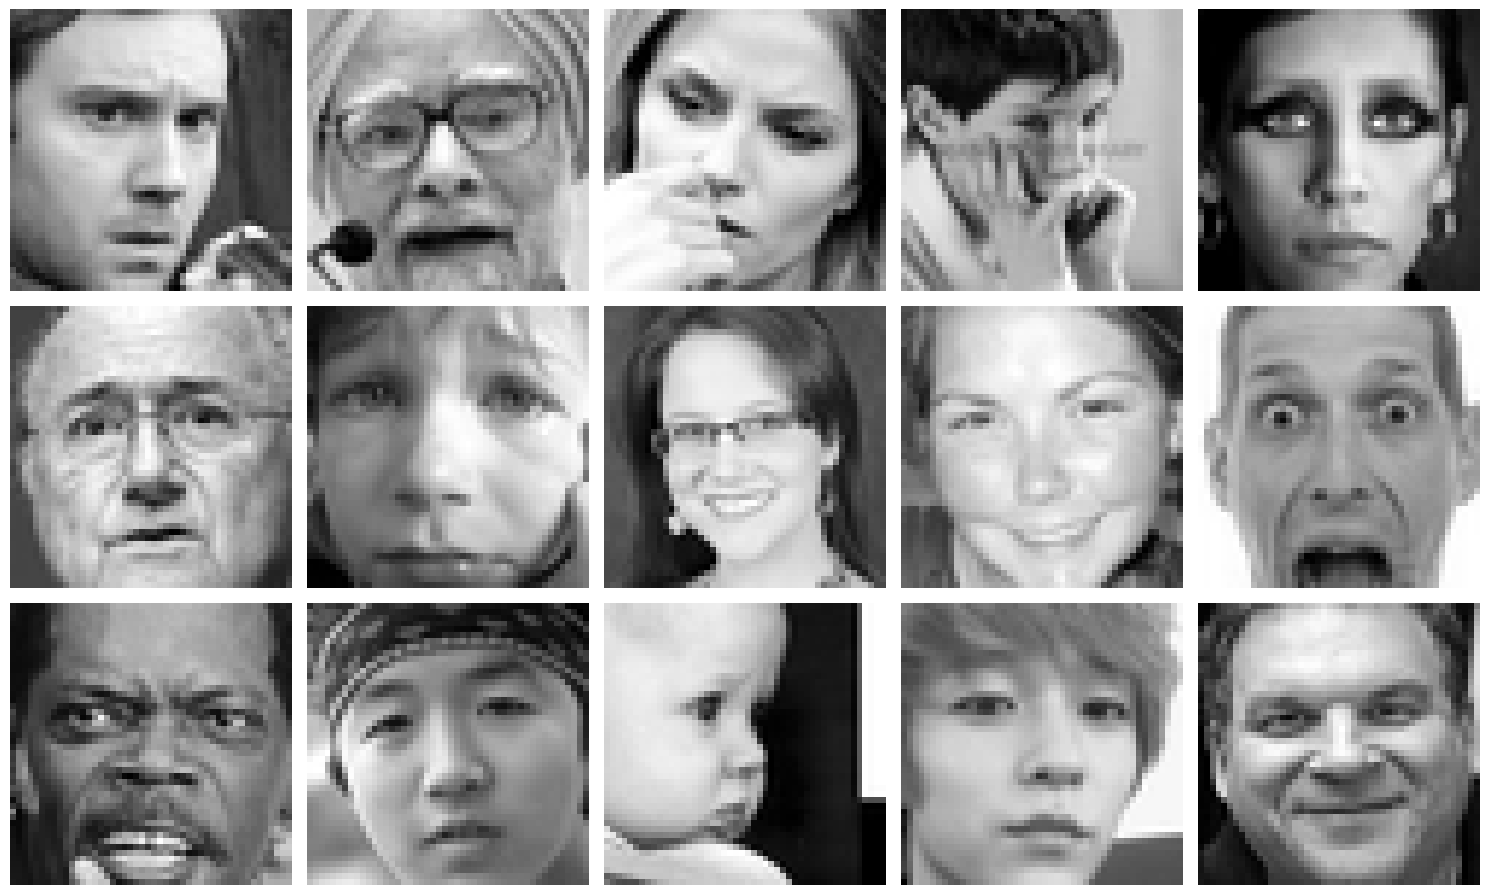

In [64]:
def plot_dataset_images():
    plt.style.use('ggplot')
    
    plt.figure(figsize=(15, 15))
    for i in range(15):
        plt.subplot(5, 5, i+1)
        plt.imshow(X_train[i].reshape((48, 48)), cmap="gray")
        plt.axis('off')
        plt.tight_layout()

plot_dataset_images()

# 4. Defining Model Architecture

In [65]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'same', activation = 'relu', input_shape = (48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 32, kernel_size = (4, 4), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (5, 5), padding = 'same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(7, activation='softmax'))
    
    return model
    
model = create_model()

# 5. Training Model

In [66]:
EPOCHS = 150
BATCH_SIZE = 128

In [67]:
datagen = ImageDataGenerator(rotation_range = 10,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.1,
                            horizontal_flip = True,
                            fill_mode = 'nearest')

In [68]:
custom_optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.0001)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=custom_optimizer)

In [69]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)

callback_list = [reduce_lr, early_stopping]

Epoch 1/150
225/225 [==============================] - 13s 50ms/step - loss: 1.8750 - accuracy: 0.2778 - val_loss: 1.7571 - val_accuracy: 0.2914 - lr: 0.0100
Epoch 2/150
225/225 [==============================] - 9s 42ms/step - loss: 1.6711 - accuracy: 0.3364 - val_loss: 1.5663 - val_accuracy: 0.3993 - lr: 0.0100
Epoch 3/150
225/225 [==============================] - 10s 44ms/step - loss: 1.6032 - accuracy: 0.3725 - val_loss: 1.4938 - val_accuracy: 0.4129 - lr: 0.0100
Epoch 4/150
225/225 [==============================] - 10s 47ms/step - loss: 1.5421 - accuracy: 0.3983 - val_loss: 1.4891 - val_accuracy: 0.4140 - lr: 0.0100
Epoch 5/150
225/225 [==============================] - 10s 42ms/step - loss: 1.4942 - accuracy: 0.4197 - val_loss: 1.4858 - val_accuracy: 0.4283 - lr: 0.0100
Epoch 6/150
225/225 [==============================] - 10s 42ms/step - loss: 1.4501 - accuracy: 0.4387 - val_loss: 1.4659 - val_accuracy: 0.4458 - lr: 0.0100
Epoch 7/150
225/225 [==============================] 

Epoch 52/150
225/225 [==============================] - 8s 36ms/step - loss: 0.8884 - accuracy: 0.6726 - val_loss: 1.0571 - val_accuracy: 0.6116 - lr: 0.0050
Epoch 53/150
225/225 [==============================] - 8s 37ms/step - loss: 0.8892 - accuracy: 0.6667 - val_loss: 1.0654 - val_accuracy: 0.6121 - lr: 0.0050
Epoch 54/150
225/225 [==============================] - 8s 37ms/step - loss: 0.8873 - accuracy: 0.6703 - val_loss: 1.0392 - val_accuracy: 0.6219 - lr: 0.0050
Epoch 55/150
225/225 [==============================] - 8s 36ms/step - loss: 0.8777 - accuracy: 0.6725 - val_loss: 1.0872 - val_accuracy: 0.5977 - lr: 0.0050
Epoch 56/150
225/225 [==============================] - 8s 36ms/step - loss: 0.8703 - accuracy: 0.6760 - val_loss: 1.0753 - val_accuracy: 0.6016 - lr: 0.0050
Epoch 57/150
225/225 [==============================] - 8s 37ms/step - loss: 0.8737 - accuracy: 0.6762 - val_loss: 1.0440 - val_accuracy: 0.6211 - lr: 0.0050
Epoch 58/150
225/225 [==============================

Epoch 101/150
225/225 [==============================] - 9s 39ms/step - loss: 0.7587 - accuracy: 0.7206 - val_loss: 1.0343 - val_accuracy: 0.6303 - lr: 6.2500e-04
Epoch 102/150
225/225 [==============================] - 8s 37ms/step - loss: 0.7571 - accuracy: 0.7198 - val_loss: 1.0373 - val_accuracy: 0.6300 - lr: 6.2500e-04
Epoch 103/150
225/225 [==============================] - 8s 36ms/step - loss: 0.7602 - accuracy: 0.7191 - val_loss: 1.0343 - val_accuracy: 0.6311 - lr: 6.2500e-04
Epoch 104/150
225/225 [==============================] - 8s 36ms/step - loss: 0.7669 - accuracy: 0.7135 - val_loss: 1.0346 - val_accuracy: 0.6308 - lr: 6.2500e-04
Epoch 105/150
225/225 [==============================] - 8s 37ms/step - loss: 0.7623 - accuracy: 0.7190 - val_loss: 1.0352 - val_accuracy: 0.6325 - lr: 6.2500e-04


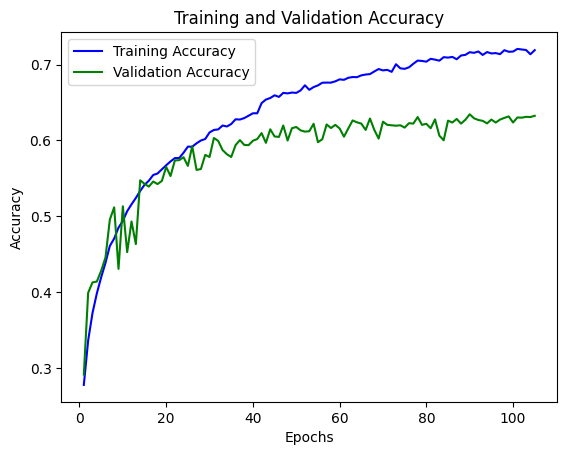

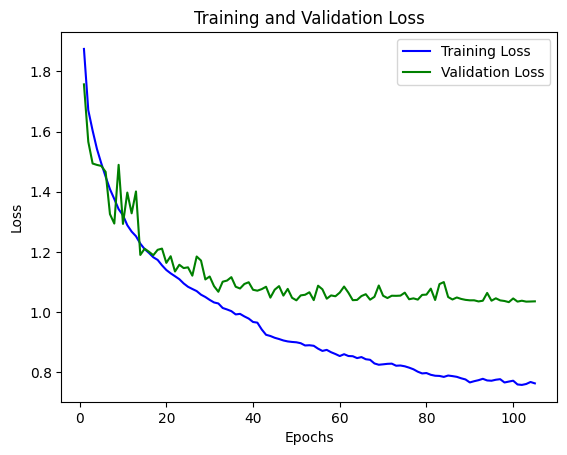

In [70]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size = BATCH_SIZE),
    validation_data = (X_val, y_val),
    epochs = EPOCHS,
    callbacks = callback_list
)

plot(history)

# 6. Testing Model

In [78]:
model.evaluate(x = X_test, y = y_test, batch_size = 1)

3589/3589 [==============================] - 13s 4ms/step - loss: 0.9792 - accuracy: 0.6556


[0.9792382717132568, 0.6556143760681152]

3589/3589 [==============================] - 8s 2ms/step
Test Accuracy: 0.6556143760681152
Test Loss: 0.9792414903640747


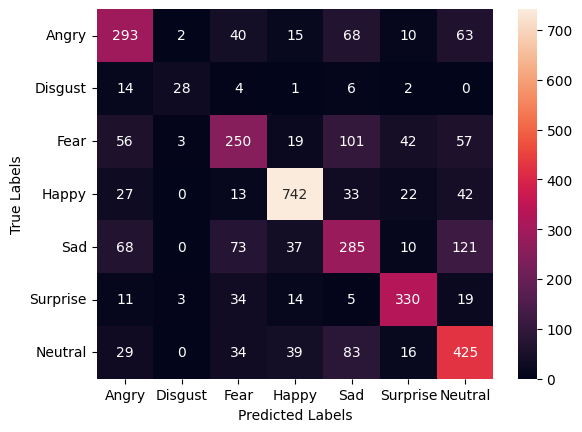

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def test_model(trained_model):
    batch_size = 1
    y_pred = trained_model.predict(X_test, batch_size = batch_size)
    y_pred_classes = np.argmax(y_pred, axis = 1)
    test_loss, test_acc = trained_model.evaluate(X_test, y_test, verbose = 0)
    
    axis_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    
    print('Test Accuracy:', test_acc)
    print('Test Loss:', test_loss)
    
    cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred_classes)
    hp = sns.heatmap(cm, annot = True, fmt='d', xticklabels=axis_labels, yticklabels=axis_labels)
    
    hp.set_xlabel("Predicted Labels")
    hp.set_ylabel("True Labels")
    
    plt.show()
    
test_model(model)

In [77]:
model.save('final_model.h5')